In [1]:
import os
import numpy as np 
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
# from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,Dropout
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, r2_score, mean_squared_error
from math import sqrt


In [2]:
IMG_SHAPE = (350,350)
IMG_SHAPE_GN = (350,350,3)

In [2]:
# Process image (input) for the model
def process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SHAPE)
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

# Read image
def get_image(path):
    image = cv2.imread(path)
    if image is None or image.size == 0:
        print(f"Error loading image from path: {path}")
        return None

    try:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    except Exception as e:
        print(f"Error converting image from path {path}: {e}")
        return None
    
# Visualize samples
def visualize_samples(datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    filepaths = "D:/periodontitis/archive/" + filepaths
    images = filepaths.apply(get_image).reset_index(drop=True)
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            if images[sample_index] is not None:  # Skip over images that failed to load
                ax[i,j].imshow(images[sample_index])
                ax[i,j].set_title(labels[sample_index])
                ax[i,j].set_axis_off()
    plt.show()
    
    
# Make classifications & visualize results
def visualize_classifications(model, datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    filepaths = "D:/periodontitis/archive" + filepaths
#     print(filepaths[0])
    images = filepaths.apply(get_image).reset_index(drop=True)
    processed_images = np.vstack(images.apply(process).to_numpy()[:])
    
    y_pred = classes[np.argmax(model.predict(processed_images, verbose=0), axis=1)]
    y_pred = pd.Series(y_pred).replace({"penyakit-non-periodontal":"NOT Periodontal", "penyakit-periodontal":"Periodontal"}).to_numpy()
    y_true = labels
    y_true = pd.Series(labels).replace({"penyakit-non-periodontal":"NOT Periodontal", "penyakit-periodontal":"Periodontal"}).to_numpy()
    
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            is_correct_answer = "correct" if y_pred[sample_index] == y_true[sample_index] else "wrong"
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(f"({y_pred[sample_index]}) [{is_correct_answer}]")
            ax[i,j].set_axis_off()
    plt.show()
    
def sched(epoch, lr):
    return lr * tf.math.exp(-0.1)

In [4]:
import cv2
import numpy as np
from skimage import exposure
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border


In [5]:
def preprocess_and_segment(image_path):
    # Read the radiographic image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image to a standard size
    target_size = (512, 512)
    image = cv2.resize(image, target_size)

    # Apply histogram equalization for better contrast
    image = exposure.equalize_hist(image)

    # Apply Otsu's thresholding to segment the image
    threshold_value = threshold_otsu(image)
    binary_mask = image > threshold_value

    # Clear border artifacts (optional)
    binary_mask = clear_border(binary_mask)

    # Return the processed image and the segmented mask
    return binary_mask.astype(np.uint8) * 255  # Convert boolean mask to an 8-bit image
def preprocess_and_segment_directory(directory_path):
    # List all image files in the directory
    image_files = [f for f in os.listdir(directory_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    processed_images = []

    # Loop through each file and preprocess and segment
    for image_file in image_files:
        image_path = os.path.join(directory_path, image_file)
        segmented_mask = preprocess_and_segment(image_path)
        processed_images.append(segmented_mask)

    return processed_images
# Replace with your actual directory path
directory_path = "D:/periodontitis/archive/test"
segmented_images = preprocess_and_segment_directory(directory_path)

# segmented_images now contains all the segmented images from the directory
def visualize_segmented_images(images, row_col_len=4, figsize=None):
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            if sample_index < len(images):  # Check if the index is within the range of available images
                ax[i, j].imshow(images[sample_index], cmap='gray')
                ax[i, j].set_axis_off()
    plt.show()

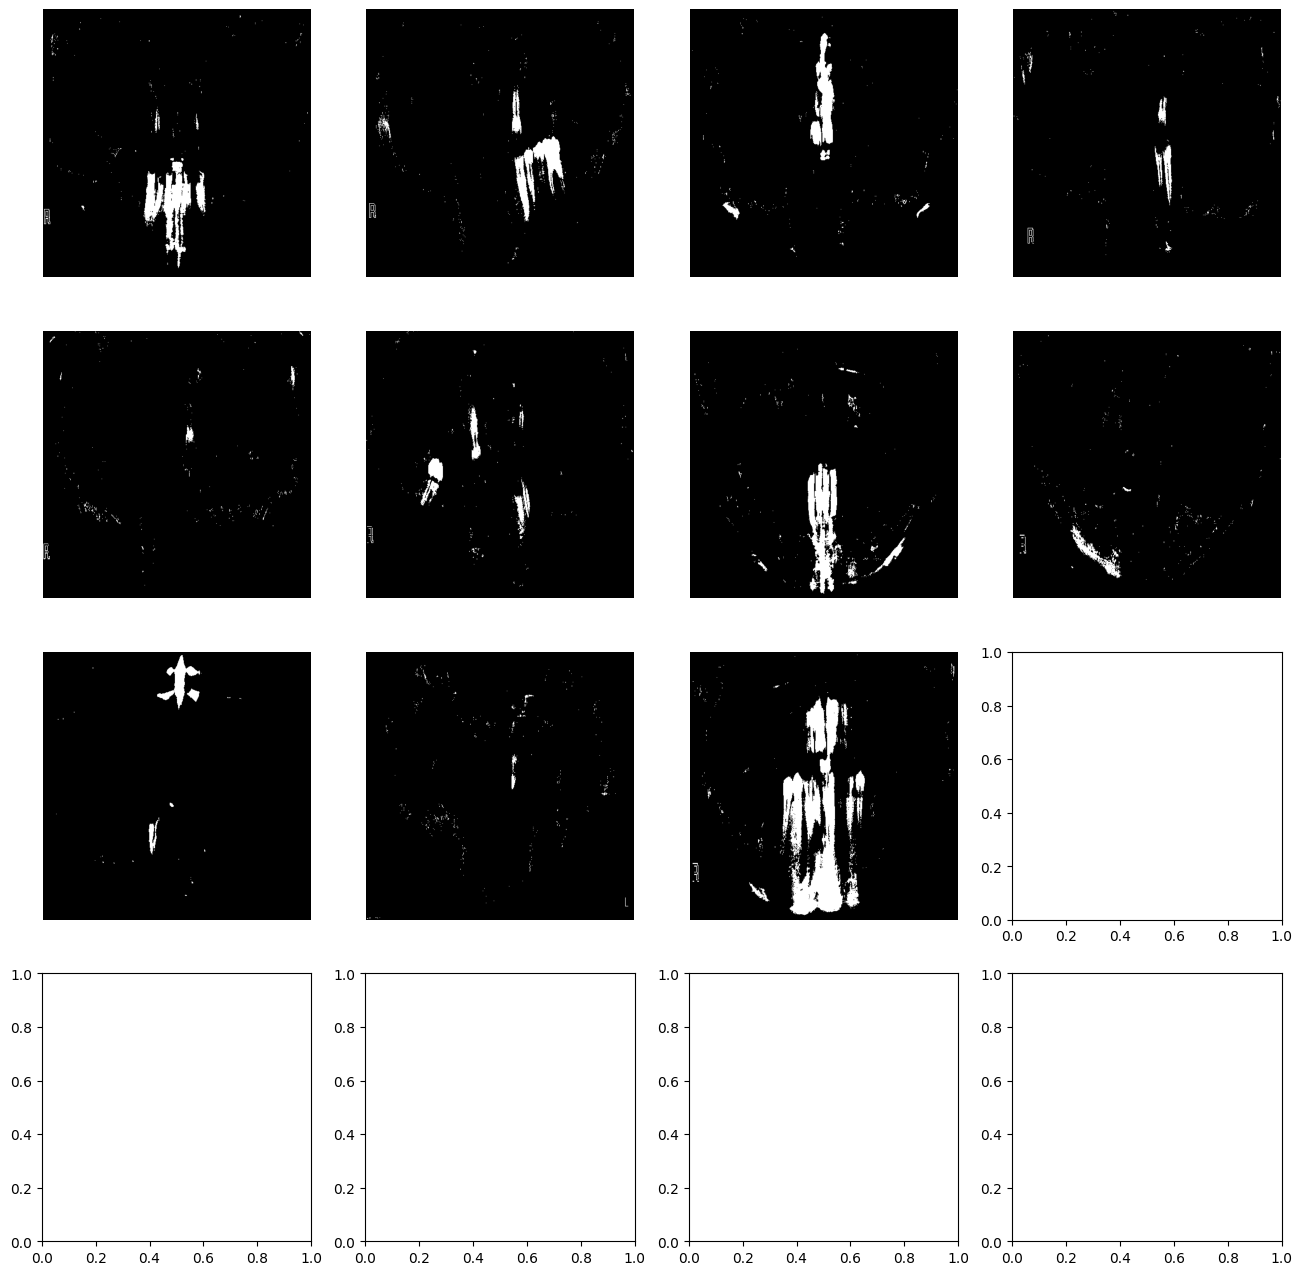

In [6]:
visualize_segmented_images(segmented_images)

In [7]:
train_datagen = ImageDataGenerator(    
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2,
  )


validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
)

In [8]:
train_gen_flow = train_datagen.flow_from_directory(
        directory="D:/periodontitis/archive",
        target_size=IMG_SHAPE,
        batch_size=64,
        class_mode="binary",
        subset='training'
)

valid_gen_flow = validation_datagen.flow_from_directory(
        directory="D:/periodontitis/archive",
        target_size=IMG_SHAPE,
        batch_size=64,
        class_mode="binary",
        subset='validation')

Found 809 images belonging to 3 classes.
Found 202 images belonging to 3 classes.


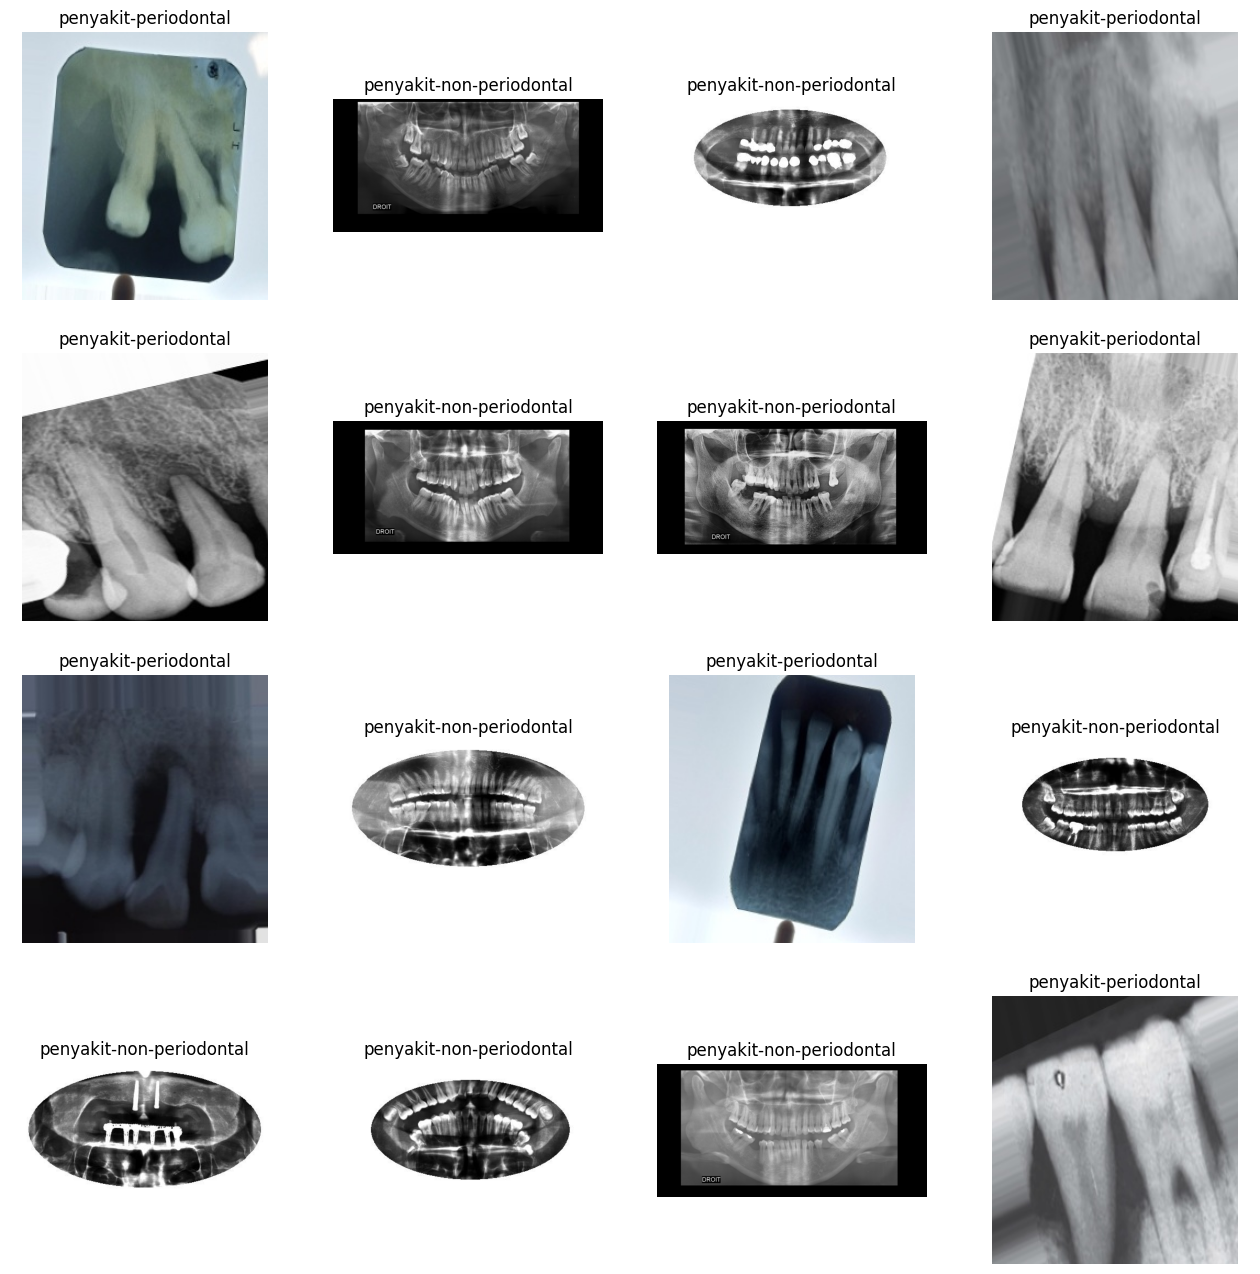

In [9]:
visualize_samples(train_gen_flow)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the CNN model
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SHAPE_GN))
model.add(MaxPooling2D((2, 2)))

# Convolutional layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Convolutional layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layer 1
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))  # Dropout layer to reduce overfitting

# Fully connected layer 2
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# Fully connected layer 3
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall()])

# Display the model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 348, 348, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 174, 174, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 172, 172, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 86, 86, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 84, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 42, 42, 128)       0

In [11]:
history = model.fit(
    train_gen_flow,
    epochs=20,  
    validation_data=valid_gen_flow,
    callbacks=[tf.keras.callbacks.LearningRateScheduler(sched)]
)


Epoch 1/20
13/13 [==============================] - 99s 7s/step - loss: 0.8126 - accuracy: 0.6267 - recall: 0.5208 - val_loss: 0.0713 - val_accuracy: 0.9901 - val_recall: 0.9804 - lr: 9.0484e-04
Epoch 2/20
13/13 [==============================] - 105s 8s/step - loss: 0.3728 - accuracy: 0.8319 - recall: 0.8068 - val_loss: 0.0616 - val_accuracy: 0.9901 - val_recall: 0.9804 - lr: 8.1873e-04
Epoch 3/20
13/13 [==============================] - 105s 8s/step - loss: 0.2020 - accuracy: 0.9197 - recall: 0.8949 - val_loss: 0.0483 - val_accuracy: 0.9901 - val_recall: 0.9804 - lr: 7.4082e-04
Epoch 4/20
13/13 [==============================] - 81s 6s/step - loss: 0.1712 - accuracy: 0.9135 - recall: 0.9120 - val_loss: 0.0292 - val_accuracy: 0.9901 - val_recall: 0.9804 - lr: 6.7032e-04
Epoch 5/20
13/13 [==============================] - 81s 6s/step - loss: 0.1622 - accuracy: 0.9209 - recall: 0.9291 - val_loss: 0.0638 - val_accuracy: 0.9901 - val_recall: 0.9804 - lr: 6.0653e-04
Epoch 6/20
13/13 [=====

In [12]:
print("Model Evaluation")
score = model.evaluate(valid_gen_flow)

Model Evaluation
4/4 [==============================] - 3s 717ms/step - loss: 0.0288 - accuracy: 0.9901 - recall: 0.9804


In [14]:
model.save("PeriodontalClassifierCNN.h5")

In [20]:
def classify_new_image(model_path, image_path):
    model = tf.keras.models.load_model(model_path)

    image = get_image(image_path)
    if image is None:
        return "Image could not be loaded or processed."

    processed_image = process(image)

    prediction = model.predict(processed_image)
    predicted_class = "Periodontal" if prediction[0] > 0.5 else "NOT Periodontal"

    return predicted_class

image_path = "D:/periodontitis/archive/test/periodontal_22.png"
model_path = "D:/periodontitis/archive/PeriodontalClassifierCNN.h5"
result = classify_new_image(model_path, image_path)
print(f"The image was classified as: {result}")

1/1 [==============================] - 0s 115ms/step
The image was classified as: Periodontal


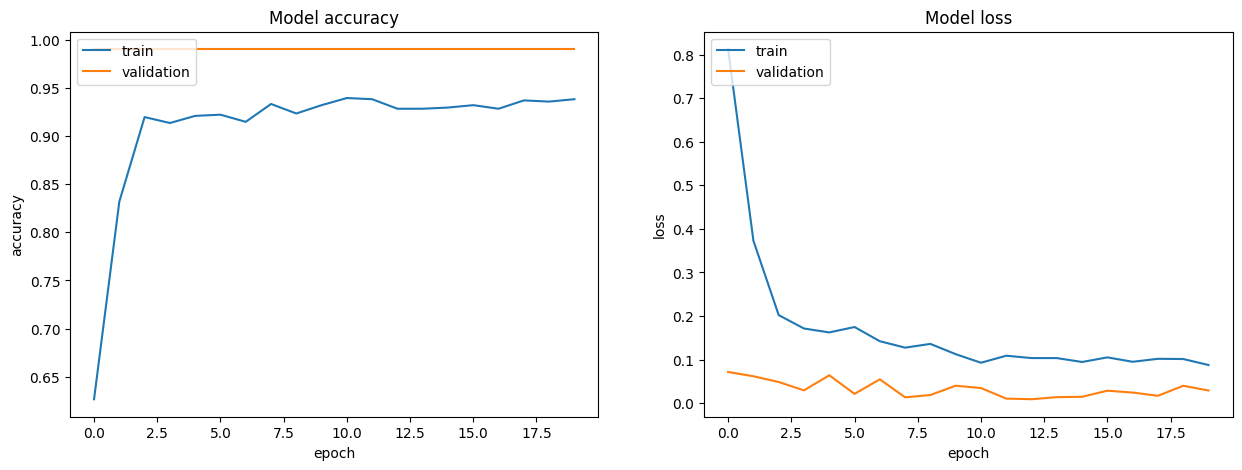

In [21]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_train_history(history)